# Evaluation of the `Hagrad`-Optimizer with cifar10-Dataset

"Hagrad" - **Ha**miltonian **Gr**adient **D**escent, based on Maddison, C. J., Paulin, D., Teh, Y. W., O'Donoghue, B., & Doucet, A. (2018). *Hamiltonia Descent Methods*. [arXiv:1809.05042 [math.OC]](arXiv:1809.05042).

Implementation of custom `tf`/`tf.keras` optimizer inspired by [https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/](https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/)

### Imports and Data

In [28]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Hagrad custom optimizer
from hagrad import Hagrad

In [29]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [30]:
y_test  = y_test.flatten()
y_train = y_train.flatten()

In [31]:
## Class number and sanity check
num_classes = 10
assert np.all(np.sort(np.unique(y_train)) == np.arange(num_classes))

## Normalizing and expanding dimensions for ConvLayers
def perpare_X_data(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32) / 255.
    return(X)

X_train = perpare_X_data(X_train)
X_test  = perpare_X_data(X_test)

## convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

### Separation of a validation set

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.1)

### Defining Model generating function

Convnet inspired by https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/.

In [33]:
def generate_model(
    input_shape: tuple,
    num_classes: int,
    opt: keras.optimizers.Optimizer,
    PRINT_SUMMARY: bool=False
) -> keras.Model:
    model = keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.3),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.3),
            layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.4),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.4),
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    
    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=["accuracy"])

    if PRINT_SUMMARY: print(model.summary())

    return(model)


## Train Models

In [34]:
batch_size  = 32
epochs      = 200
input_shape = X_train.shape[1:]
print(input_shape)

(32, 32, 3)


### Train baseline with SGD and Adam

In [35]:
keras.backend.clear_session()
model_adam = generate_model(input_shape=input_shape, num_classes=num_classes, opt=keras.optimizers.Adam(), PRINT_SUMMARY=True)
fit_adam = model_adam.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0

In [36]:
keras.backend.clear_session()
model_sgd = generate_model(input_shape=input_shape, num_classes=num_classes, opt=keras.optimizers.SGD(), PRINT_SUMMARY=False)
fit_sgd = model_sgd.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/200
1407/1407 [==============================] - 11s 8ms/step - loss: 2.2098 - accuracy: 0.1834 - val_loss: 1.9224 - val_accuracy: 0.2534
Epoch 2/200
1407/1407 [==============================] - 10s 7ms/step - loss: 1.9415 - accuracy: 0.2558 - val_loss: 1.7865 - val_accuracy: 0.3040
Epoch 3/200
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8269 - accuracy: 0.3072 - val_loss: 1.8751 - val_accuracy: 0.3016
Epoch 4/200
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7456 - accuracy: 0.3408 - val_loss: 1.6458 - val_accuracy: 0.3526
Epoch 5/200
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6764 - accuracy: 0.3705 - val_loss: 1.7232 - val_accuracy: 0.3830
Epoch 6/200
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6221 - accuracy: 0.3953 - val_loss: 1.5156 - val_accuracy: 0.4420
Epoch 7/200
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5791 - accuracy: 0.4166 - val_loss: 1.4248 -

In [45]:
keras.backend.clear_session()
model_hagrad = generate_model(input_shape=input_shape, num_classes=num_classes, opt=Hagrad(epsilon=1., gamma=10.,), PRINT_SUMMARY=False)
fit_hagrad = model_hagrad.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/200
1407/1407 [==============================] - 19s 12ms/step - loss: 2.1392 - accuracy: 0.2226 - val_loss: 1.7923 - val_accuracy: 0.3268
Epoch 2/200
1407/1407 [==============================] - 17s 12ms/step - loss: 1.8345 - accuracy: 0.3361 - val_loss: 1.5285 - val_accuracy: 0.4422
Epoch 3/200
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5346 - accuracy: 0.4438 - val_loss: 1.3750 - val_accuracy: 0.4950
Epoch 4/200
1407/1407 [==============================] - 17s 12ms/step - loss: 1.3576 - accuracy: 0.5100 - val_loss: 1.2240 - val_accuracy: 0.5582
Epoch 5/200
1407/1407 [==============================] - 17s 12ms/step - loss: 1.2734 - accuracy: 0.5485 - val_loss: 1.0314 - val_accuracy: 0.6210
Epoch 6/200
1407/1407 [==============================] - 17s 12ms/step - loss: 1.2033 - accuracy: 0.5747 - val_loss: 1.0005 - val_accuracy: 0.6402
Epoch 7/200
1407/1407 [==============================] - 17s 12ms/step - loss: 1.1519 - accuracy: 0.5944 - val_loss: 0

In [46]:
keras.backend.clear_session()
model_hagrad2 = generate_model(
    input_shape=input_shape, 
    num_classes=num_classes, 
    opt=Hagrad(epsilon=1., gamma=10., kinetic_energy="classical"), 
    PRINT_SUMMARY=False
    )

fit_hagrad2 = model_hagrad2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/200
1407/1407 [==============================] - 17s 11ms/step - loss: 2.2108 - accuracy: 0.1888 - val_loss: 1.9928 - val_accuracy: 0.2318
Epoch 2/200
1407/1407 [==============================] - 15s 10ms/step - loss: 1.9765 - accuracy: 0.2754 - val_loss: 1.6330 - val_accuracy: 0.4030
Epoch 3/200
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7039 - accuracy: 0.3743 - val_loss: 1.4178 - val_accuracy: 0.4468
Epoch 4/200
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4918 - accuracy: 0.4578 - val_loss: 1.3030 - val_accuracy: 0.5118
Epoch 5/200
1407/1407 [==============================] - 16s 11ms/step - loss: 1.3651 - accuracy: 0.5098 - val_loss: 1.1606 - val_accuracy: 0.5784
Epoch 6/200
1407/1407 [==============================] - 16s 11ms/step - loss: 1.2746 - accuracy: 0.5464 - val_loss: 1.0188 - val_accuracy: 0.6274
Epoch 7/200
1407/1407 [==============================] - 15s 11ms/step - loss: 1.2065 - accuracy: 0.5731 - val_loss: 0

KeyboardInterrupt: 

## Visualizing

In [47]:
epochs_arr = np.arange(epochs)

## Keras is evaluating the validation error in the end of each epoch. 
#  Therefore these values get shifted for the visualization:
epochs_arr_val = epochs_arr + 0.5

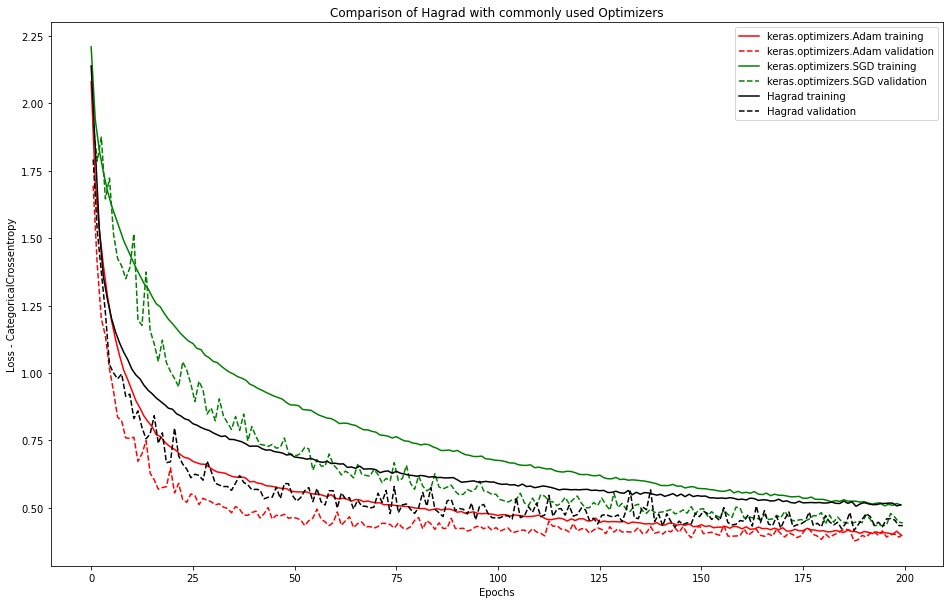

In [48]:
plt.figure(figsize=(16, 10))
plt.title("Comparison of Hagrad with commonly used Optimizers")
plt.plot(epochs_arr, fit_adam.history['loss'], "r-", label="keras.optimizers.Adam training") 
plt.plot(epochs_arr_val, fit_adam.history['val_loss'], "r--", label="keras.optimizers.Adam validation") 
plt.plot(epochs_arr, fit_sgd.history['loss'], "g-", label="keras.optimizers.SGD training") 
plt.plot(epochs_arr_val, fit_sgd.history['val_loss'], "g--", label="keras.optimizers.SGD validation") 
plt.plot(epochs_arr, fit_hagrad.history['loss'], "k-", label="Hagrad training") 
plt.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="Hagrad validation") 
plt.xlabel("Epochs")
plt.ylabel("Loss - CategoricalCrossentropy")
plt.legend()
plt.show()